# Explicit Feedback Neural Recommender Systems

Goals:
- Understand recommender data
- Build different models architectures using Keras
- Retrieve Embeddings and visualize them
- Add metadata information as input to the model

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os.path as op

from zipfile import ZipFile
try:
    from urllib.request import urlretrieve
except ImportError:  # Python 2 compat
    from urllib import urlretrieve


ML_100K_URL = "http://files.grouplens.org/datasets/movielens/ml-100k.zip"
ML_100K_FILENAME = ML_100K_URL.rsplit('/', 1)[1]
ML_100K_FOLDER = 'ml-100k'

if not op.exists(ML_100K_FILENAME):
    print('Downloading %s to %s...' % (ML_100K_URL, ML_100K_FILENAME))
    urlretrieve(ML_100K_URL, ML_100K_FILENAME)

if not op.exists(ML_100K_FOLDER):
    print('Extracting %s to %s...' % (ML_100K_FILENAME, ML_100K_FOLDER))
    ZipFile(ML_100K_FILENAME).extractall('.')

Extracting ml-100k.zip to ml-100k...


### Ratings file

Each line contains a rated movie: 
- a user
- an item
- a rating from 1 to 5 stars

In [2]:
import pandas as pd

raw_ratings = pd.read_csv(op.join(ML_100K_FOLDER, 'u.data'), sep='\t',
                      names=["user_id", "item_id", "rating", "timestamp"])
raw_ratings.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


### Item metadata file

The item metadata file contains metadata like the name of the movie or the date it was released. The movies file contains columns indicating the movie's genres. Let's only load the first five columns of the file with `usecols`.

In [3]:
m_cols = ['item_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
items = pd.read_csv(op.join(ML_100K_FOLDER, 'u.item'), sep='|',
                    names=m_cols, usecols=range(5), encoding='latin-1')
items.head()

,item_id,title,release_date,video_release_date,imdb_url
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995)


Let's write a bit of Python preprocessing code to extract the release year as an integer value:

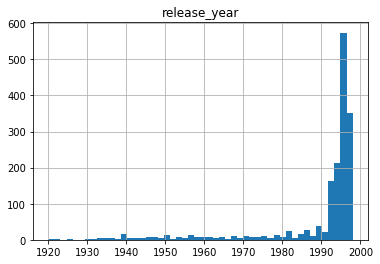

In [4]:
def extract_year(release_date):
    if hasattr(release_date, 'split'):
        components = release_date.split('-')
        if len(components) == 3:
            return int(components[2])
    # Missing value marker
    return 1920


items['release_year'] = items['release_date'].map(extract_year)
items.hist('release_year', bins=50);

Enrich the raw ratings data with the collected items metadata:

In [0]:
all_ratings = pd.merge(items, raw_ratings)

In [6]:
all_ratings.head()

,item_id,title,release_date,video_release_date,imdb_url,release_year,user_id,rating,timestamp
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,308,4,887736532
1,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,287,5,875334088
2,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,148,4,877019411
3,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,280,4,891700426
4,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,66,3,883601324


### Data preprocessing

To understand well the distribution of the data, the following statistics are computed:
- the number of users
- the number of items
- the rating distribution
- the popularity of each movie

In [7]:
min_user_id = all_ratings['user_id'].min()
min_user_id

1

In [8]:
max_user_id = all_ratings['user_id'].max()
max_user_id

943

In [9]:
min_item_id = all_ratings['item_id'].min()
min_item_id

1

In [10]:
max_item_id = all_ratings['item_id'].max()
max_item_id

1682

In [11]:
all_ratings['rating'].describe()

count    100000.000000
mean          3.529860
std           1.125674
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

Let's do a bit more pandas magic compute the popularity of each movie (number of ratings):

In [12]:
popularity = all_ratings.groupby('item_id').size().reset_index(name='popularity')
items = pd.merge(popularity, items)
items.nlargest(10, 'popularity')

,item_id,popularity,title,release_date,video_release_date,imdb_url,release_year
49,50,583,Star Wars (1977),01-Jan-1977,NaN,http://us.imdb.com/M/title-exact?Star%20Wars%2...,1977
257,258,509,Contact (1997),11-Jul-1997,NaN,http://us.imdb.com/Title?Contact+(1997/I),1997
99,100,508,Fargo (1996),14-Feb-1997,NaN,http://us.imdb.com/M/title-exact?Fargo%20(1996),1997
180,181,507,Return of the Jedi (1983),14-Mar-1997,NaN,http://us.imdb.com/M/title-exact?Return%20of%2...,1997
293,294,485,Liar Liar (1997),21-Mar-1997,NaN,http://us.imdb.com/Title?Liar+Liar+(1997),1997
285,286,481,"English Patient, The (1996)",15-Nov-1996,NaN,http://us.imdb.com/M/title-exact?English%20Pat...,1996
287,288,478,Scream (1996),20-Dec-1996,NaN,http://us.imdb.com/M/title-exact?Scream%20(1996),1996
0,1,452,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995
299,300,431,Air Force One (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Air+Force+One...,1997
120,121,429,Independence Day (ID4) (1996),03-Jul-1996,NaN,http://us.imdb.com/M/title-exact?Independence%...,1996


In [13]:
items["title"][181]

'GoodFellas (1990)'

In [14]:
indexed_items = items.set_index('item_id')
indexed_items["title"][181]

'Return of the Jedi (1983)'

In [15]:
all_ratings = pd.merge(popularity, all_ratings)
all_ratings.describe()

,item_id,popularity,video_release_date,release_year,user_id,rating,timestamp
count,100000.000000,100000.000000,0.0,100000.000000,100000.00000,100000.000000,1.000000e+05
mean,425.530130,168.071900,NaN,1987.950100,462.48475,3.529860,8.835289e+08
std,330.798356,121.784558,NaN,14.169558,266.61442,1.125674,5.343856e+06
min,1.000000,1.000000,NaN,1920.000000,1.00000,1.000000,8.747247e+08
25%,175.000000,71.000000,NaN,1986.000000,254.00000,3.000000,8.794487e+08
50%,322.000000,145.000000,NaN,1994.000000,447.00000,4.000000,8.828269e+08
75%,631.000000,239.000000,NaN,1996.000000,682.00000,4.000000,8.882600e+08
max,1682.000000,583.000000,NaN,1998.000000,943.00000,5.000000,8.932866e+08


In [16]:
all_ratings.head()

,item_id,popularity,title,release_date,video_release_date,imdb_url,release_year,user_id,rating,timestamp
0,1,452,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,308,4,887736532
1,1,452,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,287,5,875334088
2,1,452,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,148,4,877019411
3,1,452,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,280,4,891700426
4,1,452,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,66,3,883601324


Later in the analysis we will assume that this popularity does not come from the ratings themselves but from an external metadata, e.g. box office numbers in the month after the release in movie theaters.

Let's split the enriched data in a train / test split to make it possible to do predictive modeling:

In [0]:
from sklearn.model_selection import train_test_split

ratings_train, ratings_test = train_test_split(
    all_ratings, test_size=0.2, random_state=0)

user_id_train = np.array(ratings_train['user_id'])
item_id_train = np.array(ratings_train['item_id'])
rating_train = np.array(ratings_train['rating'])

user_id_test = np.array(ratings_test['user_id'])
item_id_test = np.array(ratings_test['item_id'])
rating_test = np.array(ratings_test['rating'])

# Explicit feedback: supervised ratings prediction

For each pair of (user, item) try to predict the rating the user would give to the item.

This is the classical setup for building recommender systems from offline data with explicit supervision signal. 

## Predictive ratings  as a regression problem

The following code implements the following architecture:


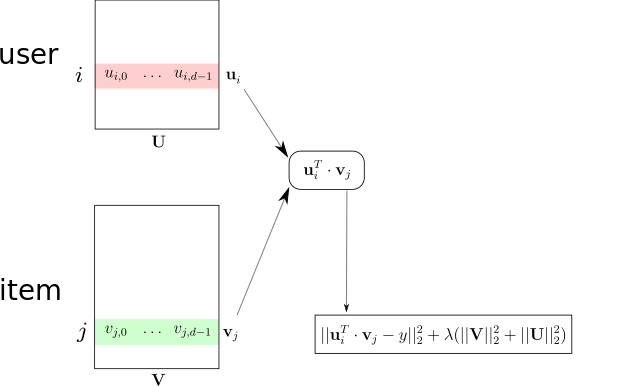

In [69]:
from IPython.display import Image
Image('rec_archi_1.png', width=600)

In [0]:
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout
from tensorflow.keras.layers import Dot
from tensorflow.keras.models import Model

In [19]:
# For each sample we input the integer identifiers
# of a single user and a single item
class RegressionModel(Model):
    def __init__(self, embedding_size, max_user_id, max_item_id):
        super().__init__()
        
        self.user_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_user_id + 1,
                                        input_length=1,
                                        name='user_embedding')
        self.item_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_item_id + 1,
                                        input_length=1,
                                        name='item_embedding')
        
        # The following two layers don't have parameters.
        self.flatten = Flatten()
        self.dot = Dot(axes=1)
        
    def call(self, inputs):
        user_inputs = inputs[0]
        item_inputs = inputs[1]
        
        user_vecs = self.flatten(self.user_embedding(user_inputs))
        item_vecs = self.flatten(self.item_embedding(item_inputs))
        
        y = self.dot([user_vecs, item_vecs])
        return y


model = RegressionModel(64, max_user_id, max_item_id)
model.compile(optimizer="adam", loss='mae')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [20]:
# Useful for debugging the output shape of model
initial_train_preds = model.predict([user_id_train, item_id_train])
initial_train_preds.shape

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


(80000, 1)

### Model error

Using `initial_train_preds`, compute the model errors:
- mean absolute error
- mean squared error

Converting a pandas Series to numpy array is usually implicit, but you may use `rating_train.values` to do so explicitly. Be sure to monitor the shapes of each object you deal with by using `object.shape`.

In [21]:
# %load solutions/compute_errors.py
squared_differences = np.square(initial_train_preds[:,0] - rating_train)
absolute_differences = np.abs(initial_train_preds[:,0] - rating_train)

print("Random init MSE: %0.3f" % np.mean(squared_differences))
print("Random init MAE: %0.3f" % np.mean(absolute_differences))

# You may also use sklearn metrics to do so using scikit-learn:

from sklearn.metrics import mean_absolute_error, mean_squared_error

print("Random init MSE: %0.3f" % mean_squared_error(initial_train_preds, rating_train))
print("Random init MAE: %0.3f" % mean_absolute_error(initial_train_preds, rating_train))


Random init MSE: 13.720
Random init MAE: 3.529
Random init MSE: 13.720
Random init MAE: 3.529


### Monitoring runs

Keras enables to monitor various variables during training. 

`history.history` returned by the `model.fit` function is a dictionary
containing the `'loss'` and validation loss `'val_loss'` after each epoch

In [22]:
%%time

# Training the model
history = model.fit([user_id_train, item_id_train], rating_train,
                    batch_size=64, epochs=10, validation_split=0.1,
                    shuffle=True)

Train on 72000 samples, validate on 8000 samples
Epoch 1/10
72000/72000 [==============================] - 3s 45us/sample - loss: 2.6765 - val_loss: 1.0600
Epoch 2/10
72000/72000 [==============================] - 3s 44us/sample - loss: 0.8538 - val_loss: 0.7956
Epoch 3/10
72000/72000 [==============================] - 3s 43us/sample - loss: 0.7545 - val_loss: 0.7647
Epoch 4/10
72000/72000 [==============================] - 3s 43us/sample - loss: 0.7276 - val_loss: 0.7513
Epoch 5/10
72000/72000 [==============================] - 3s 43us/sample - loss: 0.7056 - val_loss: 0.7468
Epoch 6/10
72000/72000 [==============================] - 3s 43us/sample - loss: 0.6847 - val_loss: 0.7425
Epoch 7/10
72000/72000 [==============================] - 3s 43us/sample - loss: 0.6652 - val_loss: 0.7382
Epoch 8/10
72000/72000 [==============================] - 3s 44us/sample - loss: 0.6438 - val_loss: 0.7354
Epoch 9/10
72000/72000 [==============================] - 3s 44us/sample - loss: 0.6211 - val_l

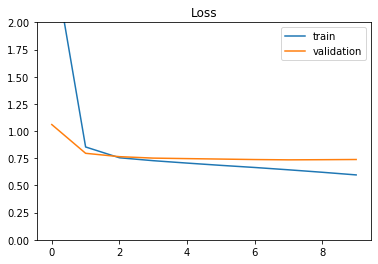

In [23]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylim(0, 2)
plt.legend(loc='best')
plt.title('Loss');

**Questions**:

- Why is the train loss higher than the first loss in the first few epochs?
- Why is Keras not computing the train loss on the full training set at the end of each epoch as it does on the validation set?


Now that the model is trained, the model MSE and MAE look nicer:

In [0]:
def plot_predictions(y_true, y_pred):
    plt.figure(figsize=(4, 4))
    plt.xlim(-1, 6)
    plt.xlabel("True rating")
    plt.ylim(-1, 6)
    plt.xlabel("Predicted rating")
    plt.scatter(y_true, y_pred, s=60, alpha=0.01)

Final test MSE: 0.889
Final test MAE: 0.729


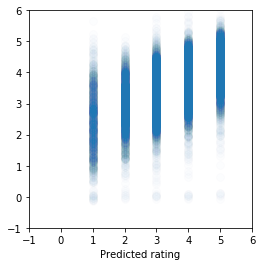

In [25]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

test_preds = model.predict([user_id_test, item_id_test])
print("Final test MSE: %0.3f" % mean_squared_error(test_preds, rating_test))
print("Final test MAE: %0.3f" % mean_absolute_error(test_preds, rating_test))
plot_predictions(rating_test, test_preds)

Final train MSE: 0.622
Final train MAE: 0.577


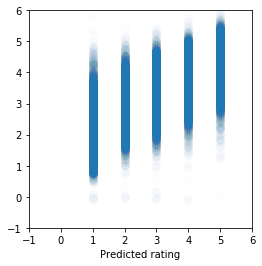

In [26]:
train_preds = model.predict([user_id_train, item_id_train])
print("Final train MSE: %0.3f" % mean_squared_error(train_preds, rating_train))
print("Final train MAE: %0.3f" % mean_absolute_error(train_preds, rating_train))
plot_predictions(rating_train, train_preds)

### Model Embeddings

- It is possible to retrieve the embeddings by simply using the Keras function `model.get_weights` which returns all the model learnable parameters.
- The weights are returned the same order as they were build in the model
- What is the total number of parameters?

In [27]:
# weights and shape
weights = model.get_weights()
[w.shape for w in weights]

[(944, 64), (1683, 64)]

In [0]:
# Solution: 
# model.summary()

In [0]:
user_embeddings = weights[0]
item_embeddings = weights[1]

In [30]:
item_id = 181
print(f"Title for item_id={item_id}: {indexed_items['title'][item_id]}")

Title for item_id=181: Return of the Jedi (1983)


In [31]:
print(f"Embedding vector for item_id={item_id}")
print(item_embeddings[item_id])
print("shape:", item_embeddings[item_id].shape)

Embedding vector for item_id=181
[-0.1223809   0.35224092  0.01106843 -0.3548185   0.06717856  0.30822137
  0.3815416  -0.43465337 -0.1461048  -0.1041069   0.37373814  0.22419915
 -0.3749233   0.5078507   0.45341748  0.34631786 -0.16377932 -0.3737825
 -0.26545122 -0.47549334 -0.15362495 -0.3956864   0.54430234 -0.32549646
 -0.09521419  0.42512095 -0.5118505  -0.45071158 -0.30035108 -0.36058134
 -0.26269916  0.5253425   0.18719305 -0.16542234 -0.56861037 -0.30353183
 -0.27316126 -0.3698235  -0.3303001  -0.22963959 -0.21928902 -0.48516625
 -0.03513336 -0.10746755  0.3375004   0.23824042  0.3746407  -0.06241262
  0.05455384 -0.04203117 -0.3088555   0.05154789 -0.12316945  0.21301335
 -0.01677757 -0.48200256  0.00888807 -0.4062389   0.4394091   0.02885934
 -0.48321998 -0.04596816  0.37748563  0.5045857 ]
shape: (64,)


### Finding most similar items

Finding k most similar items to a point in embedding space

- Write in numpy a function to compute the cosine similarity between two points in embedding space.
- Test it on the following cells to check the similarities between popular movies.
- Bonus: try to generalize the function to compute the similarities between one movie and all the others and return the most related movies.

Notes:
- you may use `np.linalg.norm` to compute the norm of vector, and you may specify the `axis=`
- the numpy function `np.argsort(...)` enables to compute the sorted indices of a vector
- `items["name"][idxs]` returns the names of the items indexed by array idxs

In [0]:
EPSILON = 1e-07  # to avoid division by 0.


def cosine(x, y):
    # TODO: implement me!
    return 0.

In [0]:
# %load solutions/similarity.py
EPSILON = 1e-07


def cosine(x, y):
    dot_products = np.dot(x, y.T)
    norm_products = np.linalg.norm(x) * np.linalg.norm(y)
    return dot_products / (norm_products + EPSILON)


In [34]:
def print_similarity(item_a, item_b, item_embeddings, titles):
    print(titles[item_a])
    print(titles[item_b])
    similarity = cosine(item_embeddings[item_a],
                        item_embeddings[item_b])
    print(f"Cosine similarity: {similarity:.3}")
    
print_similarity(50, 181, item_embeddings, indexed_items["title"])

Star Wars (1977)
Return of the Jedi (1983)
Cosine similarity: 0.92


In [35]:
print_similarity(181, 288, item_embeddings, indexed_items["title"])

Return of the Jedi (1983)
Scream (1996)
Cosine similarity: 0.764


In [36]:
print_similarity(181, 1, item_embeddings, indexed_items["title"])

Return of the Jedi (1983)
Toy Story (1995)
Cosine similarity: 0.815


In [37]:
print_similarity(181, 181, item_embeddings, indexed_items["title"])

Return of the Jedi (1983)
Return of the Jedi (1983)
Cosine similarity: 1.0


In [38]:
def cosine_similarities(item_id, item_embeddings):
    """Compute similarities between item_id and all items embeddings"""
    query_vector = item_embeddings[item_id]
    dot_products = item_embeddings @ query_vector

    query_vector_norm = np.linalg.norm(query_vector)
    all_item_norms = np.linalg.norm(item_embeddings, axis=1)
    norm_products = query_vector_norm * all_item_norms
    return dot_products / (norm_products + EPSILON)


similarities = cosine_similarities(181, item_embeddings)
similarities

array([0.03052905, 0.81483537, 0.7720688 , ..., 0.67535406, 0.80427927,
       0.6638487 ], dtype=float32)

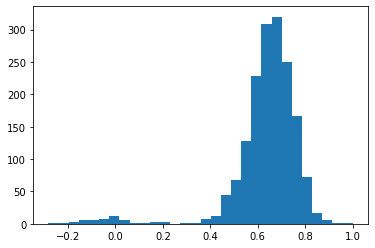

In [39]:
plt.hist(similarities, bins=30);

In [40]:
def most_similar(item_id, item_embeddings, titles,
                 top_n=30):
    sims = cosine_similarities(item_id, item_embeddings)
    # [::-1] makes it possible to reverse the order of a numpy
    # array, this is required because most similar items have
    # a larger cosine similarity value
    sorted_indexes = np.argsort(sims)[::-1]
    idxs = sorted_indexes[0:top_n]
    return list(zip(idxs, titles[idxs], sims[idxs]))


most_similar(50, item_embeddings, indexed_items["title"], top_n=10)

[(50, 'Star Wars (1977)', 1.0000001),
 (181, 'Return of the Jedi (1983)', 0.92047393),
 (174, 'Raiders of the Lost Ark (1981)', 0.9191527),
 (172, 'Empire Strikes Back, The (1980)', 0.9071878),
 (173, 'Princess Bride, The (1987)', 0.9045387),
 (204, 'Back to the Future (1985)', 0.8999336),
 (12, 'Usual Suspects, The (1995)', 0.88377136),
 (64, 'Shawshank Redemption, The (1994)', 0.88073575),
 (96, 'Terminator 2: Judgment Day (1991)', 0.8754163),
 (265, 'Hunt for Red October, The (1990)', 0.867723)]

In [0]:
# items[items['title'].str.contains("Star Trek")]

In [42]:
most_similar(227, item_embeddings, indexed_items["title"], top_n=10)

[(227, 'Star Trek VI: The Undiscovered Country (1991)', 1.0),
 (354, 'Wedding Singer, The (1998)', 0.8747482),
 (787, 'Roommates (1995)', 0.87337613),
 (233, 'Under Siege (1992)', 0.8618613),
 (1000, 'Lightning Jack (1994)', 0.85872245),
 (1238, 'Full Speed (1996)', 0.85671675),
 (431, 'Highlander (1986)', 0.8561665),
 (778, 'Don Juan DeMarco (1995)', 0.8540088),
 (101, 'Heavy Metal (1981)', 0.8536571),
 (109, 'Mystery Science Theater 3000: The Movie (1996)', 0.8530137)]

The similarities do not always make sense: the number of ratings is low and the embedding  does not automatically capture semantic relationships in that context. Better representations arise with higher number of ratings, and less overfitting  in models or maybe better loss function, such as those based on implicit feedback.

### Visualizing embeddings using TSNE

- we use scikit learn to visualize items embeddings
- Try different perplexities, and visualize user embeddings as well
- What can you conclude ?

In [0]:
from sklearn.manifold import TSNE

item_tsne = TSNE(perplexity=30).fit_transform(item_embeddings)

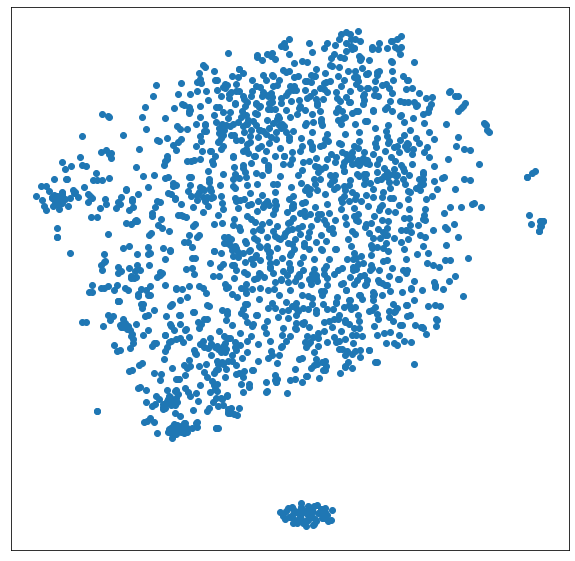

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.scatter(item_tsne[:, 0], item_tsne[:, 1]);
plt.xticks(()); plt.yticks(());
plt.show()

In [0]:
%pip install -q plotly

In [46]:
import plotly.express as px

tsne_df = pd.DataFrame(item_tsne, columns=["tsne_1", "tsne_2"])
tsne_df["item_id"] = np.arange(item_tsne.shape[0])
tsne_df = tsne_df.merge(items.reset_index())

px.scatter(tsne_df, x="tsne_1", y="tsne_2",
           color="popularity",
           hover_data=["item_id", "title",
                       "release_year", "popularity"])

Alternatively with [Uniform Manifold Approximation and Projection](https://github.com/lmcinnes/umap):

In [0]:
 %pip install umap-learn

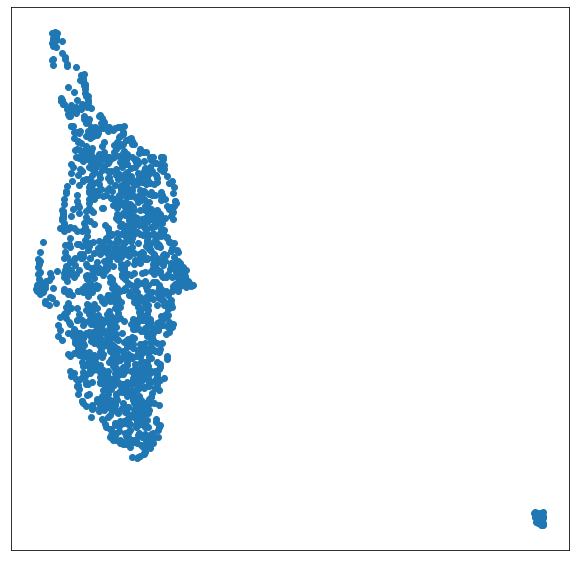

In [73]:
import umap

item_umap = umap.UMAP().fit_transform(item_embeddings)
plt.figure(figsize=(10, 10))
plt.scatter(item_umap[:, 0], item_umap[:, 1]);
plt.xticks(()); plt.yticks(());
plt.show()

## A Deep recommender model

Using a similar framework as previously, the following deep model described in the course was built (with only two fully connected)



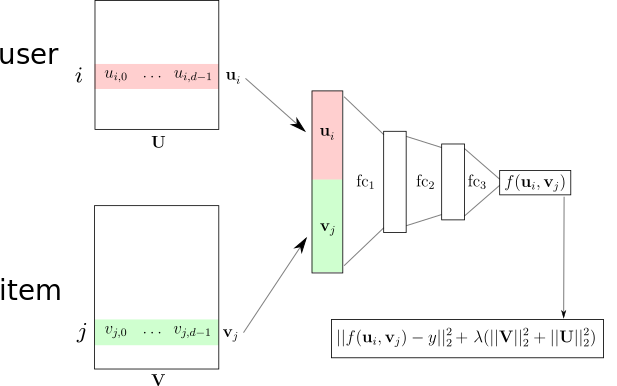

In [74]:
from IPython.display import Image
Image('rec_archi_2.png', width=600)


To build this model we will need a new kind of layer:

In [0]:
from tensorflow.keras.layers import Concatenate


### Exercise

- The following code has **4 errors** that prevent it from working correctly. **Correct them and explain** why they are critical.

In [50]:
class DeepRegressionModel(Model):

    def __init__(self, embedding_size, max_user_id, max_item_id):
        super().__init__()
        
        self.user_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_user_id + 1,
                                        input_length=1,
                                        name='user_embedding')
        self.item_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_item_id + 1,
                                        input_length=1,
                                        name='item_embedding')
        
        # The following two layers don't have parameters.
        self.flatten = Flatten()
        self.concat = Concatenate()
        
        self.dropout = Dropout(0.99)
        self.dense1 = Dense(64, activation="relu")
        self.dense2 = Dense(2, activation="tanh")
        
    def call(self, inputs):
        user_inputs = inputs[0]
        item_inputs = inputs[1]
        
        user_vecs = self.flatten(self.user_embedding(user_inputs))
        item_vecs = self.flatten(self.item_embedding(item_inputs))
        
        input_vecs = self.concat([user_vecs, item_vecs])
        
        y = self.dropout(input_vecs)
        y = self.dense1(y)
        y = self.dense2(y)
        
        return y
        
model = DeepRegressionModel(64, max_user_id, max_item_id)
model.compile(optimizer='adam', loss='binary_crossentropy')

initial_train_preds = model.predict([user_id_train, item_id_train])

In [0]:
# %load solutions/deep_explicit_feedback_recsys.py
# For each sample we input the integer identifiers
# of a single user and a single item
class DeepRegressionModel(Model):

    def __init__(self, embedding_size, max_user_id, max_item_id):
        super().__init__()

        self.user_embedding = Embedding(
            output_dim=embedding_size,
            input_dim=max_user_id + 1,
            input_length=1,
            name='user_embedding'
        )
        self.item_embedding = Embedding(
            output_dim=embedding_size,
            input_dim=max_item_id + 1,
            input_length=1,
            name='item_embedding'
        )

        # The following two layers don't have parameters.
        self.flatten = Flatten()
        self.concat = Concatenate()

        ## Error 1: Dropout was too high, preventing any training
        self.dropout = Dropout(0.5)
        self.dense1 = Dense(64, activation="relu")
        ## Error 2: output dimension was 2 where we predict only 1-d rating
        ## Error 3: tanh activation squashes the outputs between -1 and 1
        ## when we want to predict values between 1 and 5
        self.dense2 = Dense(1)

    def call(self, inputs, training=False):
        user_inputs = inputs[0]
        item_inputs = inputs[1]

        user_vecs = self.flatten(self.user_embedding(user_inputs))
        item_vecs = self.flatten(self.item_embedding(item_inputs))

        input_vecs = self.concat([user_vecs, item_vecs])

        y = self.dropout(input_vecs, training=training)
        y = self.dense1(y)
        y = self.dropout(y, training=training)
        y = self.dense2(y)

        return y


model = DeepRegressionModel(64, max_user_id, max_item_id)
## Error 4: A binary crossentropy loss is only useful for binary
## classification, while we are in regression (use mse or mae)
model.compile(optimizer='adam', loss='mae')

initial_train_preds = model.predict([user_id_train, item_id_train])


In [52]:
%%time
history = model.fit([user_id_train, item_id_train], rating_train,
                    batch_size=64, epochs=10, validation_split=0.1,
                    shuffle=True)

Train on 72000 samples, validate on 8000 samples
Epoch 1/10
72000/72000 [==============================] - 4s 54us/sample - loss: 1.1256 - val_loss: 0.7850
Epoch 2/10
72000/72000 [==============================] - 4s 50us/sample - loss: 0.8743 - val_loss: 0.7568
Epoch 3/10
72000/72000 [==============================] - 4s 49us/sample - loss: 0.8427 - val_loss: 0.7617
Epoch 4/10
72000/72000 [==============================] - 4s 49us/sample - loss: 0.8152 - val_loss: 0.7497
Epoch 5/10
72000/72000 [==============================] - 4s 50us/sample - loss: 0.7937 - val_loss: 0.7505
Epoch 6/10
72000/72000 [==============================] - 4s 50us/sample - loss: 0.7778 - val_loss: 0.7465
Epoch 7/10
72000/72000 [==============================] - 4s 50us/sample - loss: 0.7654 - val_loss: 0.7431
Epoch 8/10
72000/72000 [==============================] - 4s 50us/sample - loss: 0.7541 - val_loss: 0.7420
Epoch 9/10
72000/72000 [==============================] - 4s 49us/sample - loss: 0.7440 - val_l

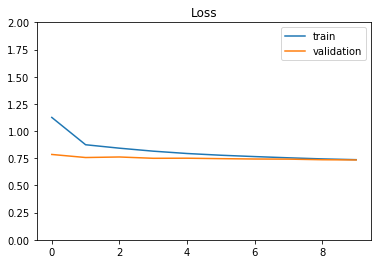

In [53]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylim(0, 2)
plt.legend(loc='best')
plt.title('Loss');

In [54]:
train_preds = model.predict([user_id_train, item_id_train])
print("Final train MSE: %0.3f" % mean_squared_error(train_preds, rating_train))
print("Final train MAE: %0.3f" % mean_absolute_error(train_preds, rating_train))

Final train MSE: 0.840
Final train MAE: 0.700


In [55]:
test_preds = model.predict([user_id_test, item_id_test])
print("Final test MSE: %0.3f" % mean_squared_error(test_preds, rating_test))
print("Final test MAE: %0.3f" % mean_absolute_error(test_preds, rating_test))

Final test MSE: 0.899
Final test MAE: 0.731


The performance of this model is not necessarily significantly better than the previous model but you can notice that the gap between train and test is lower, probably thanks to the use of dropout.

Furthermore this model is more flexible in the sense that we can extend it to include metadata for hybrid recsys as we will see in the following.

### Home assignment: 
 - Add another layer, compare train/test error.
 - Can you improve the test MAE? 
 - Try adding more dropout and change layer sizes.
 
 
Manual tuning of so many hyperparameters is tedious. In practice it's better to automate the design of the model using an hyperparameter search tool such as:

- https://keras-team.github.io/keras-tuner/ (Keras specific)
- https://optuna.org/ (any machine learning framework, Keras included)

## Using item metadata in the model

Using a similar framework as previously, we will build another deep model that can also leverage additional metadata. The resulting system is therefore an **Hybrid Recommender System** that does both **Collaborative Filtering** and **Content-based recommendations**.


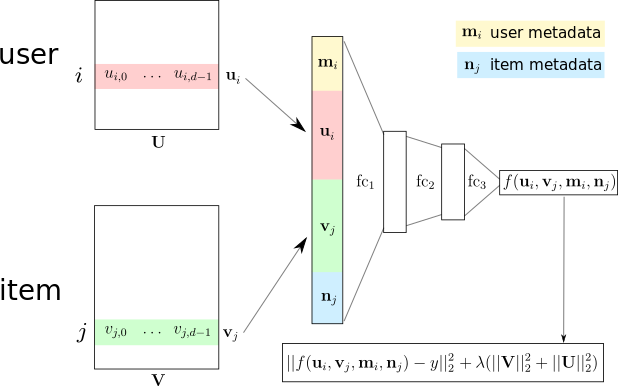

In [78]:
from IPython.display import Image
Image('rec_archi_3.png', width=600)

In [0]:
from sklearn.preprocessing import QuantileTransformer

meta_columns = ['popularity', 'release_year']

scaler = QuantileTransformer()
item_meta_train = scaler.fit_transform(ratings_train[meta_columns])
item_meta_test = scaler.transform(ratings_test[meta_columns])

In [0]:
class HybridModel(Model):

    def __init__(self, embedding_size, max_user_id, max_item_id):
        super().__init__()
        
        self.user_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_user_id + 1,
                                        input_length=1,
                                        name='user_embedding')
        self.item_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_item_id + 1,
                                        input_length=1,
                                        name='item_embedding')
        
        # The following two layers don't have parameters.
        self.flatten = Flatten()
        self.concat = Concatenate()
        
        self.dense1 = Dense(64, activation="relu")
        self.dropout = Dropout(0.3)
        self.dense2 = Dense(64, activation='relu')
        self.dense3 = Dense(1)
        
    def call(self, inputs, training=False):
        user_inputs = inputs[0]
        item_inputs = inputs[1]
        meta_inputs = inputs[2]

        user_vecs = self.flatten(self.user_embedding(user_inputs))
        user_vecs = self.dropout(user_vecs, training=training)

        item_vecs = self.flatten(self.item_embedding(item_inputs))
        item_vecs = self.dropout(item_vecs, training=training)

        input_vecs = self.concat([user_vecs, item_vecs, meta_inputs])

        y = self.dense1(input_vecs)
        y = self.dropout(y, training=training)
        y = self.dense2(y)
        y = self.dropout(y, training=training)
        y = self.dense3(y)
        return y
        
model = HybridModel(64, max_user_id, max_item_id)
model.compile(optimizer='adam', loss='mae')

initial_train_preds = model.predict([user_id_train,
                                     item_id_train,
                                     item_meta_train])

In [58]:
%%time
history = model.fit([user_id_train, item_id_train, item_meta_train],
                    rating_train,
                    batch_size=64, epochs=10, validation_split=0.1,
                    shuffle=True)

Train on 72000 samples, validate on 8000 samples
Epoch 1/10
72000/72000 [==============================] - 4s 60us/sample - loss: 0.9677 - val_loss: 0.7679
Epoch 2/10
72000/72000 [==============================] - 4s 54us/sample - loss: 0.8260 - val_loss: 0.7492
Epoch 3/10
72000/72000 [==============================] - 4s 54us/sample - loss: 0.7947 - val_loss: 0.7406
Epoch 4/10
72000/72000 [==============================] - 4s 54us/sample - loss: 0.7756 - val_loss: 0.7352
Epoch 5/10
72000/72000 [==============================] - 4s 54us/sample - loss: 0.7613 - val_loss: 0.7315
Epoch 6/10
72000/72000 [==============================] - 4s 54us/sample - loss: 0.7497 - val_loss: 0.7370
Epoch 7/10
72000/72000 [==============================] - 4s 54us/sample - loss: 0.7378 - val_loss: 0.7265
Epoch 8/10
72000/72000 [==============================] - 4s 53us/sample - loss: 0.7274 - val_loss: 0.7311
Epoch 9/10
72000/72000 [==============================] - 4s 54us/sample - loss: 0.7193 - val_l

In [59]:
test_preds = model.predict([user_id_test, item_id_test, item_meta_test])
print("Final test MSE: %0.3f" % mean_squared_error(test_preds, rating_test))
print("Final test MAE: %0.3f" % mean_absolute_error(test_preds, rating_test))

Final test MSE: 0.879
Final test MAE: 0.719


The additional metadata seems to improve the predictive power of the model a bit but this should be re-run several times to see the impact of the random initialization of the model.


### A recommendation function for a given user

Once the model is trained, the system can be used to recommend a few items for a user, that he/she hasn't already seen:
- we use the `model.predict` to compute the ratings a user would have given to all items
- we build a reco function that sorts these items and exclude those the user has already seen

In [0]:
def recommend(user_id, top_n=10):
    item_ids = range(1, max_item_id)
    seen_mask = all_ratings["user_id"] == user_id
    seen_movies = set(all_ratings[seen_mask]["item_id"])
    item_ids = list(filter(lambda x: x not in seen_movies, item_ids))

    print("User %d has seen %d movies, including:" % (user_id, len(seen_movies)))
    for title in all_ratings[seen_mask].nlargest(20, 'popularity')['title']:
        print("   ", title)
    print("Computing ratings for %d other movies:" % len(item_ids))
    
    item_ids = np.array(item_ids)
    user_ids = np.zeros_like(item_ids)
    user_ids[:] = user_id
    items_meta = scaler.transform(indexed_items[meta_columns].loc[item_ids])
    
    rating_preds = model.predict([user_ids, item_ids, items_meta])
    
    item_ids = np.argsort(rating_preds[:, 0])[::-1].tolist()
    rec_items = item_ids[:top_n]
    return [(items["title"][movie], rating_preds[movie][0])
            for movie in rec_items]

In [61]:
for title, pred_rating in recommend(5):
    print("    %0.1f: %s" % (pred_rating, title))

User 5 has seen 175 movies, including:
    Star Wars (1977)
    Fargo (1996)
    Return of the Jedi (1983)
    Toy Story (1995)
    Independence Day (ID4) (1996)
    Raiders of the Lost Ark (1981)
    Silence of the Lambs, The (1991)
    Empire Strikes Back, The (1980)
    Star Trek: First Contact (1996)
    Back to the Future (1985)
    Mission: Impossible (1996)
    Fugitive, The (1993)
    Indiana Jones and the Last Crusade (1989)
    Willy Wonka and the Chocolate Factory (1971)
    Princess Bride, The (1987)
    Forrest Gump (1994)
    Monty Python and the Holy Grail (1974)
    Men in Black (1997)
    E.T. the Extra-Terrestrial (1982)
    Birdcage, The (1996)
Computing ratings for 1506 other movies:
    5.1: Romy and Michele's High School Reunion (1997)
    4.8: August (1996)
    4.8: Robocop 3 (1993)
    4.8: Boys of St. Vincent, The (1993)
    4.6: Cowboy Way, The (1994)
    4.6: Milk Money (1994)
    4.6: Last Time I Committed Suicide, The (1997)
    4.6: Mille bolle blu (1993)


### Home assignment: Predicting ratings as a classification problem

In this dataset, the ratings all belong to a finite set of possible values:

In [62]:
import numpy as np

np.unique(rating_train)

array([1, 2, 3, 4, 5])

Maybe we can help the model by forcing it to predict those values by treating the problem as a multiclassification problem. The only required changes are:

- setting the final layer to output class membership probabities using a softmax activation with 5 outputs;
- optimize the categorical cross-entropy classification loss instead of a regression loss such as MSE or MAE.

Random init MSE: 3.231
Random init MAE: 1.443
Train on 72000 samples, validate on 8000 samples
Epoch 1/15
72000/72000 [==============================] - 4s 53us/sample - loss: 1.3688 - val_loss: 1.2767
Epoch 2/15
72000/72000 [==============================] - 3s 48us/sample - loss: 1.2842 - val_loss: 1.2574
Epoch 3/15
72000/72000 [==============================] - 3s 48us/sample - loss: 1.2654 - val_loss: 1.2540
Epoch 4/15
72000/72000 [==============================] - 3s 47us/sample - loss: 1.2539 - val_loss: 1.2488
Epoch 5/15
72000/72000 [==============================] - 3s 47us/sample - loss: 1.2467 - val_loss: 1.2476
Epoch 6/15
72000/72000 [==============================] - 3s 48us/sample - loss: 1.2395 - val_loss: 1.2459
Epoch 7/15
72000/72000 [==============================] - 3s 47us/sample - loss: 1.2346 - val_loss: 1.2436
Epoch 8/15
72000/72000 [==============================] - 3s 48us/sample - loss: 1.2298 - val_loss: 1.2434
Epoch 9/15
72000/72000 [=========================

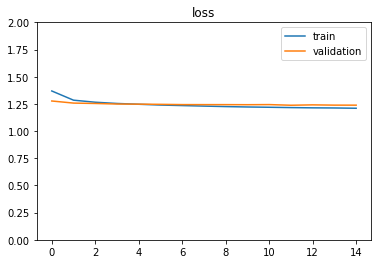

In [63]:
# %load solutions/classification.py
class ClassificationModel(Model):
    def __init__(self, embedding_size, max_user_id, max_item_id):
        super().__init__()

        self.user_embedding = Embedding(output_dim=embedding_size, input_dim=max_user_id + 1,
                                        input_length=1, name='user_embedding')
        self.item_embedding = Embedding(output_dim=embedding_size, input_dim=max_item_id + 1,
                                        input_length=1, name='item_embedding')

        # The following two layers don't have parameters.
        self.flatten = Flatten()
        self.concat = Concatenate()

        self.dropout1 = Dropout(0.5)
        self.dense1 = Dense(128, activation="relu")
        self.dropout2 = Dropout(0.2)
        self.dense2 = Dense(128, activation='relu')
        self.dense3 = Dense(5, activation="softmax")

    def call(self, inputs):
        user_inputs = inputs[0]
        item_inputs = inputs[1]

        user_vecs = self.flatten(self.user_embedding(user_inputs))
        item_vecs = self.flatten(self.item_embedding(item_inputs))

        input_vecs = self.concat([user_vecs, item_vecs])

        y = self.dropout1(input_vecs)
        y = self.dense1(y)
        y = self.dropout2(y)
        y = self.dense2(y)
        y = self.dense3(y)

        return y

model = ClassificationModel(16, max_user_id, max_item_id)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

initial_train_preds = model.predict([user_id_train, item_id_train]).argmax(axis=1) + 1
print("Random init MSE: %0.3f" % mean_squared_error(initial_train_preds, rating_train))
print("Random init MAE: %0.3f" % mean_absolute_error(initial_train_preds, rating_train))

history = model.fit([user_id_train, item_id_train], rating_train - 1,
                    batch_size=64, epochs=15, validation_split=0.1,
                    shuffle=True)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylim(0, 2)
plt.legend(loc='best')
plt.title('loss');

test_preds = model.predict([user_id_test, item_id_test]).argmax(axis=1) + 1
print("Final test MSE: %0.3f" % mean_squared_error(test_preds, rating_test))
print("Final test MAE: %0.3f" % mean_absolute_error(test_preds, rating_test))
